In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Read CSV Data
df = pd.read_csv("../data/cumulative.csv")
# Remove unnecessary features
df = df.drop(columns=["rowid", "kepid", "kepoi_name", "kepler_name", "koi_pdisposition", "koi_score", "koi_tce_delivname"])
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
# Preview "df"
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,FALSE POSITIVE,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,CONFIRMED,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


## <font color="navy">Optimize Correlation Threshold to Remove Functionally Redundant Features</font>
<i><font color="sky blue"><strong>Optimization was applied in random forest (rf) model as rf does not require the distribution pattern of data<strong></font></i>

In [3]:
# Column to be used as label
target = df["koi_disposition"]    

# Transform categorical labels to numerical
from sklearn.preprocessing import LabelEncoder
target_encoder = LabelEncoder().fit(target.values)
encd_target = target_encoder.transform(target.values)
    
# One-hot encoding labels
from tensorflow.keras.utils import to_categorical
encd_target_categ = to_categorical(encd_target)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# List to hold correlation threshold (corr_thold) to be tested in Random Forest model
corr_thold_list = range(20, 100, 5)

# Library to hold score info. for each corr_thold
corr_thold_results = {
    "corr_thold": [],
    "number of features": [],
    "testing score": []
}

# Iterate for each corr_thold
for corr_thold in corr_thold_list:
    
    # Columns to be used as features
    features = df.drop("koi_disposition", axis=1)
    # List for names of all columns from "features"
    cols = features.columns
    # List for names of functionally redudant columns to be deleted
    col_del = []
    
    for i in range(len(cols)):
        # If B and C are both closely correlated with A, appending cols[j] rather than cols[i] will delete both B and C 
        # with no exception even if they are not correlated to each other at all, which might compromise our model
        # It has been tested that deleting "cols[i]" will yield a better score given the same correlation threshold
        [col_del.append(cols[i]) for j in range(i) if abs(features[cols[i]].corr(features[cols[j]])) > corr_thold / 100]

    # Delete functionally redundant columns
    features = features.drop(columns=col_del)
    
    # Split date into train and test    
    X_train, X_test, y_train, y_test = train_test_split(features, encd_target_categ, random_state=8)
    
    # Use MinMaxScaler for normalization as we are dealing with distance metrics        
    X_scaler_mms = MinMaxScaler().fit(X_train)
    X_train_scaled_mms = X_scaler_mms.transform(X_train)
    X_test_scaled_mms = X_scaler_mms.transform(X_test)
       
    # Create random forest classifier
    rf = RandomForestClassifier(n_estimators=200)
    rf = rf.fit(X_train_scaled_mms, y_train)

    # Append results to "corr_thold_results"
    corr_thold_results["corr_thold"].append(corr_thold / 100)
    corr_thold_results["number of features"].append(features.shape[1])
    corr_thold_results["testing score"].append(rf.score(X_test_scaled_mms, y_test))

C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, fl

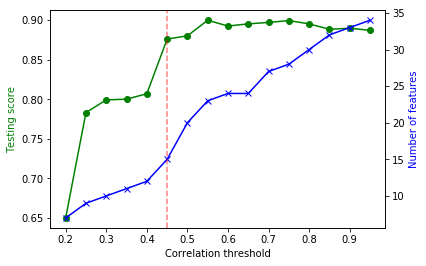

In [5]:
# Make plot for "testing score" and "number of features"
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(corr_thold_results["corr_thold"], corr_thold_results["testing score"], marker='o', color="g")
ax2.plot(corr_thold_results["corr_thold"], corr_thold_results["number of features"], marker="x", color="b")

plt.axvline(x=0.45, linestyle='dashed', c="r", alpha=0.5)

ax1.set_xlabel("Correlation threshold")
ax1.set_ylabel("Testing score", color="g")
ax2.set_ylabel("Number of features", color="b")

plt.show()

###### Based on the chart, <span style="background-color:red; color:white">correlation threshold at 0.45 with as few as 15 features</span> still retains the potential for optimized prediction

## <font color="navy">Prepare Features and Labels for Machine Learning Models</font>

In [6]:
# Set corr_thold at 0.45
corr_thold = 45

# Features used thereafter to build machine learning models (before deleting functionally redundant columns)
features = df.drop("koi_disposition", axis=1)

# List for column names to be deleted due to high correlation with others
col_del = []
# List for names of all columns from "features"
cols = features.columns

for i in range(len(cols)):
    # Append name of features (cols[i]) to "col_del" if high correlated column is found
    [col_del.append(cols[i]) for j in range(i) if abs(features[cols[i]].corr(features[cols[j]])) > corr_thold / 100]

# Delete functionally redundant columns
features = features.drop(columns=col_del)

# View names of remaining columns in features
features.columns

Index(['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_period',
       'koi_impact', 'koi_impact_err1', 'koi_duration', 'koi_depth',
       'koi_depth_err1', 'koi_teq', 'koi_insol', 'koi_tce_plnt_num',
       'koi_steff', 'ra', 'dec'],
      dtype='object')

In [7]:
# Iterate for each column in features
for col in features.columns:
    
    # Check for skewness and kurtosis
    skewness = stats.describe(features[col])[4]
    kurtosis = stats.describe(features[col])[5]
    
    # Print out column info if either skewness or kurtosis is larger than 3
    if (skewness > 3) or (kurtosis > 3):    
        print("*" * 10)
        print(f"feature name: {col}")
        print(f"skewness: {skewness}")
        print(f"kurtosis: {kurtosis}")

**********
feature name: koi_period
skewness: 2.9096056442850604
kurtosis: 8.575707227778738
**********
feature name: koi_impact
skewness: 24.545626819012853
kurtosis: 654.292256814103
**********
feature name: koi_impact_err1
skewness: 6.312551243046779
kurtosis: 40.330434371786815
**********
feature name: koi_duration
skewness: 6.142732763305333
kurtosis: 69.88306228640944
**********
feature name: koi_depth
skewness: 5.339789447449275
kurtosis: 39.95195255565689
**********
feature name: koi_depth_err1
skewness: 90.88380242228578
kurtosis: 8398.884284599475
**********
feature name: koi_teq
skewness: 3.4534017756543443
kurtosis: 27.91764996090529
**********
feature name: koi_insol
skewness: 52.04085840580866
kurtosis: 3129.058646282767
**********
feature name: koi_tce_plnt_num
skewness: 3.650882561012579
kurtosis: 16.94099602738316
**********
feature name: koi_steff
skewness: 0.7542120521681619
kurtosis: 8.074889842710324


###### Based on skewness and kurtosis study, there are two thirds columns in features whose data are not normally distributed (>3). In considering data distribution, we will use random forest, SVM, KNN, and Neural Network models thereafter

In [8]:
# Set up train and test data for all machine learning models to be built in this project
# Split date into train and test
X_train, X_test, y_train, y_test = train_test_split(features, encd_target, random_state=8)

In [9]:
# Regression models will not be used due to data distribution
# MinMaxScaler is preferred over StandardScaler for scaling features
# In this project, StandardScaler scored exactly the same as MinMaxScaler at corr_thold=0.45
X_scaler_mms = MinMaxScaler().fit(X_train)

X_train_scaled_mms = X_scaler_mms.transform(X_train)
X_test_scaled_mms = X_scaler_mms.transform(X_test)

C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## <font color="navy">Random Forest Model</font>

In [10]:
# Create random forest classifier
rf = RandomForestClassifier()

# Fit model with train data
rf = rf.fit(X_train_scaled_mms, y_train)

C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [11]:
# Scores for train and test data
print(f"Training Data Score: {rf.score(X_train_scaled_mms, y_train)}")
print(f"Testing Data Score: {rf.score(X_test_scaled_mms, y_test)}")

Training Data Score: 0.9926806953339433
Testing Data Score: 0.8700823421774931


In [13]:
# Create GridSearch estimator along with "n_estimators" and "max_features" parameters for hyperparameter tuning of the model
from sklearn.model_selection import GridSearchCV
# Set up tuning parameters
param_grid_rf = {'n_estimators': [50, 200, 500, 800],
                 'criterion': ["gini", "entropy"],
                 'max_features': ["sqrt", "log2"]
                 }
              
grid_rf = GridSearchCV(rf, param_grid_rf, verbose=3)

In [14]:
# Fit rf model using grid search estimator
grid_rf.fit(X_train_scaled_mms, y_train)

C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] criterion=gini, max_features=sqrt, n_estimators=50 ..............
[CV]  criterion=gini, max_features=sqrt, n_estimators=50, score=0.8770004572473709, total=   0.7s
[CV] criterion=gini, max_features=sqrt, n_estimators=50 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  criterion=gini, max_features=sqrt, n_estimators=50, score=0.8756287151348879, total=   0.7s
[CV] criterion=gini, max_features=sqrt, n_estimators=50 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  criterion=gini, max_features=sqrt, n_estimators=50, score=0.8681318681318682, total=   0.7s
[CV] criterion=gini, max_features=sqrt, n_estimators=200 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=200, score=0.8806584362139918, total=   3.1s
[CV] criterion=gini, max_features=sqrt, n_estimators=200 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=200, score=0.8774577046181985, total=   3.1s
[CV] criterion=gini, max_features=sqrt, n_estimators=200 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=200, score=0.8653846153846154, total=   3.1s
[CV] criterion=gini, max_features=sqrt, n_estimators=500 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=500, score=0.879286694101509, total=   7.9s
[CV] criterion=gini, max_features=sqrt, n_estimators=500 .............
[CV]  criterion=gini, max_features=sqrt, n_estimators=500, score=0.8820301783264746, total=   7.9s
[CV] criterion=gini, max_features=sqrt, n_estimators=

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  6.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 200, 500, 800], 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [15]:
 # List the best parameters for this dataset
print(grid_rf.best_params_)

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 500}


In [16]:
# Scores for train and test data after hyperparameter tuning of the model
print(f"Training Data Score: {grid_rf.score(X_train_scaled_mms, y_train)}")
print(f"Testing Data Score: {grid_rf.score(X_test_scaled_mms, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8911253430924062


In [17]:
# Calculate classification report
print(classification_report(
    y_test, grid_rf.predict(X_test_scaled_mms), target_names=["0", "1", "2"]
))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78       510
           1       0.83      0.82      0.83       587
           2       0.97      0.98      0.98      1089

   micro avg       0.89      0.89      0.89      2186
   macro avg       0.86      0.86      0.86      2186
weighted avg       0.89      0.89      0.89      2186



In [45]:
# DataFrame for test and predicted data
target_pred_test_rf = pd.DataFrame({
    "target_test": target_encoder.inverse_transform(y_test),
    "target_predicted": target_encoder.inverse_transform(grid_rf.predict(X_test_scaled_mms))
})

# Preview "target_pred_test_rf"
target_pred_test_rf.head(16)

,target_test,target_predicted
0,FALSE POSITIVE,FALSE POSITIVE
1,FALSE POSITIVE,FALSE POSITIVE
2,CONFIRMED,CONFIRMED
3,CANDIDATE,CANDIDATE
4,FALSE POSITIVE,FALSE POSITIVE
5,CONFIRMED,CONFIRMED
6,CANDIDATE,CANDIDATE
7,FALSE POSITIVE,FALSE POSITIVE
8,FALSE POSITIVE,FALSE POSITIVE
9,FALSE POSITIVE,CANDIDATE


In [59]:
# Save model as .h5 file
from sklearn.externals import joblib
joblib.dump(grid_rf.best_estimator_, '../models/kepler_rf_model.h5')

['../data/models/kepler_rf_model.h5']